# Topic Modelling - Latent Dirichlet Allocation (LDA)

**Topic modeling** is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. **Latent Dirichlet Allocation (LDA)** is an example of topic modelling and it is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
! pip install --upgrade gensim

In [6]:
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Reading in Combined Reviews CSV File

combined_reviews = pd.read_csv("/content/drive/MyDrive/UnstructuredData/DataMavericks/sentiment_reviews.csv")
combined_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(combined_reviews.shape)
combined_reviews.head(3)

(181099, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
0,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014,2,20:30:30,55,339,5.181818,13,family diner buffet eclectic assortment large ...,0.139935,0.522294,0.033,0.722,0.245,0.9201
1,5Ce3lZksYVkCbrihqylVHQ,yZdAhQ_KmKuCZmbBy9YDQg,5.0,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26,2014,7,17:56:26,98,516,4.368421,37,started going sushi nara month opened short ti...,0.376515,0.677273,0.017,0.768,0.215,0.9735
2,7L1kXfwU5XM6f6Jxo_L7Yg,hToW2eoTAYlOcuNz7I73Cg,5.0,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,2015,7,22:36:04,60,329,4.500000,21,weve coming since kid staff watched kid grow t...,0.444444,0.612963,0.000,0.738,0.262,0.9661


In [9]:
# Filtering for reviews that have 0.0 scores across 3 metrics: polarity, subjectivity, compound

dropped_reviews = combined_reviews[(combined_reviews.polarity ==0.0) & (combined_reviews.compound==0.0) & (combined_reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(281, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
159269,YSRM9nWQn40eg49tSiI-_Q,5prHC9SjSXU7oGyhQh7Adw,5.0,0,3,0,Try the battered crook. It's made by four guys...,2018-07-20 18:38:12,2018,7,18:38:12,17,91,4.411765,6,try battered crook made four guy chair smashin...,0.0,0.0,0.0,1.0,0.0,0.0
88474,34O0RW7K12gB_og8Xv3M3g,iu3sWlJDDmiIeal1-c4gaQ,1.0,0,0,0,They messed-up our order even though we explic...,2019-12-08 23:33:12,2019,12,23:33:12,75,424,4.493506,36,messedup order even though explicitly told ord...,0.0,0.0,0.0,1.0,0.0,0.0
47032,sl8Q0WCneZskxJE9DFiCcw,VQ1pnst3rb2YWnnQsnjocg,1.0,2,0,0,We came here today for lunch and when I asked ...,2018-09-11 23:09:13,2018,9,23:09:13,57,284,4.071429,27,came today lunch asked burger without bun wrap...,0.0,0.0,0.0,1.0,0.0,0.0
142945,vJdsF2pRH6pZZ16snLHSaw,3hWl59UCA5GNd4WtYHEENg,2.0,0,0,0,Veramente c0sta tropo di pui \nPer piate picc...,2021-06-29 16:59:58,2021,6,16:59:58,17,94,4.352941,1,veramente c0sta tropo di pui per piate piccolo...,0.0,0.0,0.0,1.0,0.0,0.0
80894,zwrgCMuZyFX46mL3piDyjg,umO2-QDiZ6e6lPPDF3CdOw,5.0,11,12,12,"uh, i've just been schooled...it's flapjacks t...",2014-01-27 06:51:38,2014,1,06:51:38,17,113,5.588235,5,uh ive schooledits flapjack tucson stand corre...,0.0,0.0,0.0,1.0,0.0,0.0


As seen from the table above, it seems like these reviews are written in non-english languages or are gibberish. Thus, sentimet analysis libraries are not able to compute relevant scores for these reviews. Hence, for the purpose of this project, we will be removing these `281` rows of reviews.

In [10]:
# Dropping these filtered rows

combined_reviews = combined_reviews.drop(index = dropped_reviews.index)
print(combined_reviews.shape)
combined_reviews.sample(3)

(180818, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
125009,z72q87eAdpqtLVF4jOJeFA,1TRYqzzjoI0JjpvUYv0VAQ,2.0,0,0,0,"This is the worst chick fil a I have been too,...",2019-11-08 17:10:25,2019,11,17:10:25,145,728,4.055556,68,worst chick fil isnt bad say mediocre slow ser...,-0.185417,0.531250,0.16,0.771,0.069,-0.9625
40046,C-9LDLDx0n2_3VPddBsGwA,pQUv0T9TD-EfhNJh5KkiaQ,5.0,2,0,1,I went to Tucson Tamale Company's new location...,2014-01-30 16:05:24,2014,1,16:05:24,101,497,4.223404,30,went tucson tamale company new location tanque...,0.208636,0.357314,0.00,0.841,0.159,0.9402
40528,CJoO4HYD0tZRXlZqA04wmw,zKXW8BJ6GHc9-p74fSGrHQ,5.0,0,0,0,Their white and black is awesome. Friendly sta...,2017-07-25 00:54:22,2017,7,00:54:22,20,115,4.800000,5,white black awesome friendly staff nice shop c...,0.446875,0.604167,0.00,0.422,0.578,0.9593


In [11]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['family', 'diner', 'had', 'the', 'buffet', 'eclectic', 'assortment', 'large', 'chicken', 'leg', 'fried', 'jalapeno', 'tamale', 'two', 'rolled', 'grape', 'leaves', 'fresh', 'melon', 'all', 'good', 'lots', 'of', 'mexican', 'choices', 'there', 'also', 'has', 'menu', 'with', 'breakfast', 'served', 'all', 'day', 'long', 'friendly', 'attentive', 'staff', 'good', 'place', 'for', 'casual', 'relaxed', 'meal', 'with', 'no', 'expectations', 'next', 'to', 'the', 'clarion', 'hotel']]


In [13]:
# Text Processing

import spacy
from gensim.utils import simple_preprocess

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)

In [14]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [15]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [16]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.050*"pizza" + 0.040*"bread" + 0.040*"salad" + 0.029*"coffee" + '
  '0.026*"breakfast" + 0.020*"sandwich" + 0.018*"egg" + 0.014*"cheese" + '
  '0.014*"slice" + 0.013*"free"'),
 (1,
  '0.054*"food" + 0.045*"place" + 0.039*"great" + 0.024*"service" + '
  '0.020*"love" + 0.016*"well" + 0.015*"always" + 0.015*"time" + '
  '0.015*"really" + 0.014*"restaurant"'),
 (2,
  '0.036*"order" + 0.020*"time" + 0.019*"wait" + 0.015*"food" + 0.014*"ask" + '
  '0.013*"give" + 0.011*"minute" + 0.011*"back" + 0.010*"tell" + '
  '0.010*"never"'),
 (3,
  '0.022*"order" + 0.020*"sauce" + 0.020*"fry" + 0.019*"burger" + '
  '0.018*"chicken" + 0.018*"taste" + 0.016*"flavor" + 0.013*"side" + '
  '0.011*"dish" + 0.011*"hot"'),
 (4,
  '0.027*"drink" + 0.018*"bar" + 0.018*"dinner" + 0.017*"night" + '
  '0.013*"table" + 0.012*"seat" + 0.011*"room" + 0.010*"steak" + 0.009*"area" '
  '+ 0.008*"patio"')]


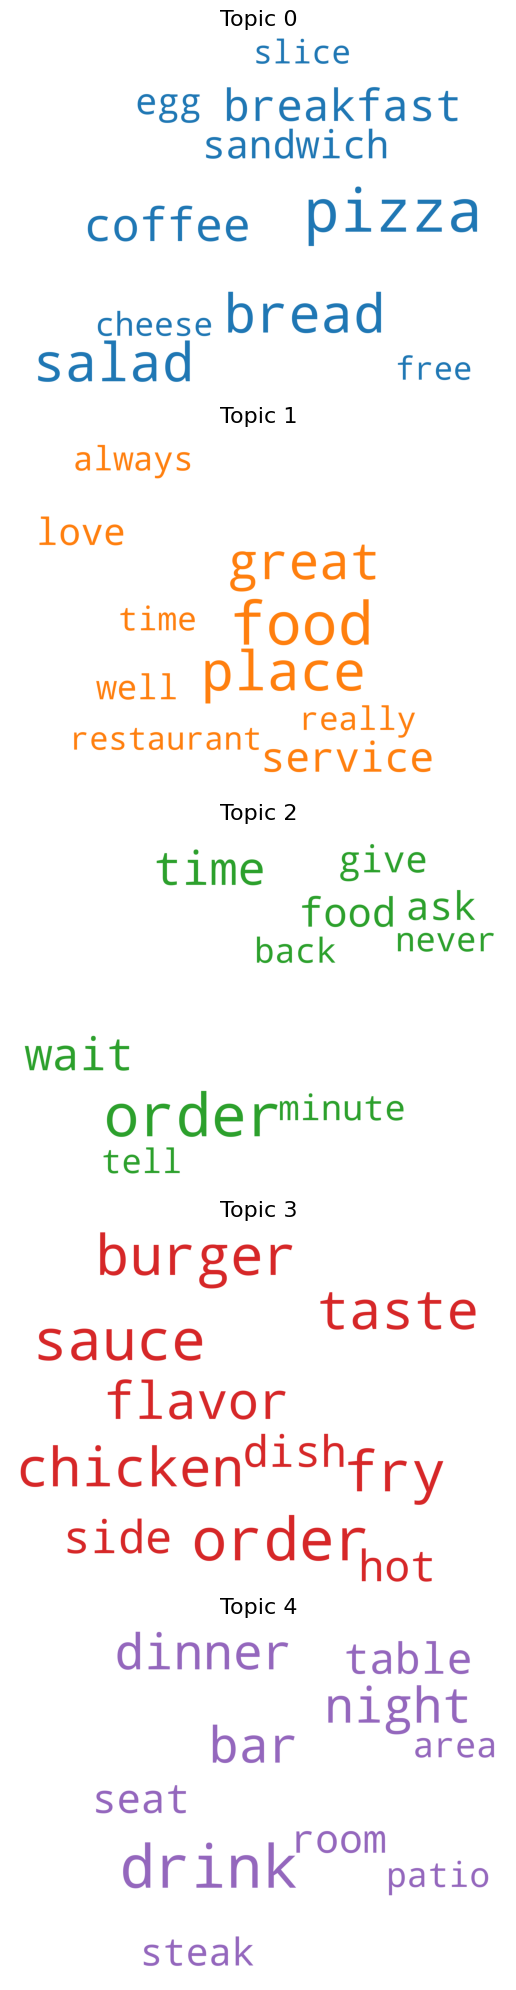

In [17]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Based on these plots, we can argue that topics 0, 3 and 4 exhibit unique characteristics as compared to topics 1 and 2
1. **Topic 0** showcases words commonly belonging to **Breakfast Cafes **. **Topic 3** showcases words belonging to **Fastfood Restaurants**. **Topic 4** showcases words belonging to **Fine dining Restaurants.**

In [ ]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.233854 -0.082421       1        1  31.833002
1      0.170069 -0.099849       2        1  29.195801
4      0.035806  0.162733       3        1  16.578291
2     -0.136861  0.218942       4        1  15.387690
3     -0.302867 -0.199405       5        1   7.005217, topic_info=        Term           Freq          Total Category  logprob  loglift
137    great  104277.000000  104277.000000  Default  30.0000  30.0000
521      fry   60671.000000   60671.000000  Default  29.0000  29.0000
696   noodle   41608.000000   41608.000000  Default  28.0000  28.0000
733  pancake   26626.000000   26626.000000  Default  27.0000  27.0000
468  chicken   60096.000000   60096.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
433  texture    5149.831055    8990.638672   Topic5  -5.0994   2.1013
59      rich    4143.426758    5508.380371   Topic5  -5.3168   2.3738
313   flavor    4904.919922   14351.921875   Topic5  -5.1481   1.5849
551      top    4375.576172   22133.123047   Topic5  -5.2623   1.0375
118   really    4172.337402   83116.515625   Topic5  -5.3098  -0.3333

[321 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
131       1  0.069692     always
131       2  0.750475     always
131       3  0.179811     always
245       2  0.999973    amazing
360       2  0.999822   ambiance
...     ...       ...        ...
79        5  0.031136       well
1564      5  0.999757       whip
558       2  0.999941       wine
2237      4  0.999938       wing
629       2  0.999957  wonderful

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

Streaming output truncated to the last 5000 lines.
<ipython-input-18-fca72f97606d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
<ipython-input-18-fca72f97606d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
<ipython-input-18-fca72f97606d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
<ipython-input-18-fca72f97606d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [20]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(180818, 4)


,Document_No,Dominant_Topic,Keywords,Text
0,0,1,"food, place, great, service, love, well, alway...","[family, eclectic, assortment, large, chicken,..."
1,1,1,"food, place, great, service, love, well, alway...","[start, month, open, short, time, ago, love, p..."
2,2,1,"food, place, great, service, love, well, alway...","[kid, staff, watch, kid, grow, personable, pro..."
3,3,1,"food, place, great, service, love, well, alway...","[blow, food, family, worth, food, hot, orange,..."
4,4,1,"food, place, great, service, love, well, alway...","[favorite, restaurant, always, order, atmosphe..."
5,5,3,"order, sauce, fry, burger, chicken, taste, fla...","[reopen, derive, new, management, rd, time, da..."
6,6,1,"food, place, great, service, love, well, alway...","[cali, common, however, place, feel, tell, pla..."
7,7,1,"food, place, great, service, love, well, alway...","[tell, place, sonoran, hot, dog, visit, town, ..."
8,8,1,"food, place, great, service, love, well, alway...","[really, prep, twice, last, month, trick, lear..."
9,9,1,"food, place, great, service, love, well, alway...","[fine, mexican, food, fry, fish, taco, wonderf..."


In [21]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([combined_reviews,extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,3.0,0.0,0.0,0.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014.0,2.0,20:30:30,55.0,339.0,5.181818,13.0,family diner buffet eclectic assortment large ...,0.139935,0.522294,0.033,0.722,0.245,0.9201,1.0,"food, place, great, service, love, well, alway...","[family, eclectic, assortment, large, chicken,..."
1,5Ce3lZksYVkCbrihqylVHQ,yZdAhQ_KmKuCZmbBy9YDQg,5.0,0.0,0.0,0.0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26,2014.0,7.0,17:56:26,98.0,516.0,4.368421,37.0,started going sushi nara month opened short ti...,0.376515,0.677273,0.017,0.768,0.215,0.9735,1.0,"food, place, great, service, love, well, alway...","[start, month, open, short, time, ago, love, p..."
2,7L1kXfwU5XM6f6Jxo_L7Yg,hToW2eoTAYlOcuNz7I73Cg,5.0,1.0,0.0,0.0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,2015.0,7.0,22:36:04,60.0,329.0,4.500000,21.0,weve coming since kid staff watched kid grow t...,0.444444,0.612963,0.000,0.738,0.262,0.9661,1.0,"food, place, great, service, love, well, alway...","[kid, staff, watch, kid, grow, personable, pro..."
3,WLiqfxv_GhFFA5sm878a2w,CysTz612pTix75Fye6-D4Q,5.0,0.0,1.0,1.0,Blew $80 on food for the family was worth it f...,2013-12-29 03:15:34,2013.0,12.0,03:15:34,31.0,151.0,3.903226,14.0,blew 80 food family worth food hot orange chic...,0.190000,0.440000,0.000,0.813,0.187,0.7707,1.0,"food, place, great, service, love, well, alway...","[blow, food, family, worth, food, hot, orange,..."
4,3YERGr7UbpSpddqL0Eiu5g,7zJVt_Bl1h5hLjhxl2c1PQ,5.0,1.0,0.0,1.0,This is my favorite restaurant! I always orde...,2017-12-16 00:18:10,2017.0,12.0,00:18:10,36.0,201.0,5.030303,15.0,favorite restaurant always order ceviche delic...,0.539286,0.692857,0.000,0.572,0.428,0.9647,1.0,"food, place, great, service, love, well, alway...","[favorite, restaurant, always, order, atmosphe..."
5,dygflr6j51vf3-lM5pUIkw,iaLZ0oJ3sqCpnW-PY5_i4w,3.0,0.0,0.0,0.0,They reopened up derived new management.. this...,2017-04-07 21:52:05,2017.0,4.0,21:52:05,102.0,556.0,4.421569,37.0,reopened derived new management 3rd time daily...,0.250043,0.603160,0.000,0.828,0.172,0.9633,3.0,"order, sauce, fry, burger, chicken, taste, fla...","[reopen, derive, new, management, rd, time, da..."
6,fgTOJRkc703E4XRdcr5zRA,FuTJWFYm4UKqewaosss1KA,3.0,3.0,0.0,0.0,I've come from Cali where boba is very common ...,2016-01-30 01:59:11,2016.0,1.0,01:59:11,201.0,1082.0,4.338308,77.0,ive come cali boba common however thinking pla...,0.250000,0.615217,0.008,0.727,0.264,0.9964,1.0,"food, place, great, service, love, well, alway...","[cali, common, however, place, feel, tell, pla..."
7,otQS34_MymijPTdNBoBdCw,17jzGkFYCvB5Q0fjJEzVAA,4.0,0.0,0.0,0.0,I was told this place is a must for a Sonoran ...,2017-06-17 17:17:29,2017.0,6.0,17:17:29,112.0,558.0,3.991071,50.0,told place must sonoran hot dog visiting town ...,0.380769,0.626923,0.000,0.729,0.271,0.9914,1.0,"food, place, great, service, love, well, alway...","[tell, place, sonoran, hot, dog, visit, town, ..."
8,UCMSWPqzXjd7QHq7v8PJjQ,_l0csyXqNIcb3vG-1qR8DQ,4.0,0.0,0.0,0.0,I really like Prep & Pastry - we have been twi...,2017-09-20 18:19:33,2017.0,9.0,18:19:33,125.0,602.0,3.917355,50.0,really like prep pastry twice last two month s...,0.370000,0.519744,0.008,0.770,0.221,0.9841,1.0,"food, place, great, service, love, well, alway...","[really, prep, twice, last, month, trick, lear..."
9,RhuYqAT45uIR2NNdDsolXQ,gSp5C3BfIVAHdH27rzoCDQ,5.0,1.0,0.0,1.0,Some of the finest Mexican food I've had. The ...,2017-07-18 18:47:24,2017.0,7.0,18:47:24,65.0,359.0,4.507692,27.0,finest mexican food ive fried fish taco wonder...,0.260000,0.420000,0.087,0.793,0.120,0.5284,1.0,"food, place, great, service, love, well, alway...","[fine, mexican, food, fry, fish,

In [22]:
# Save final_reviews into csv file

final_reviews.to_csv("/content/drive/MyDrive/UnstructuredData/DataMavericks/final_reviews.csv")